In [16]:
%load_ext autoreload
%autoreload 2
import pandas as pd 
import numpy as np
import os 
import glob
import ast 
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
from government_functions import * 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
final_df=pd.read_excel('results/complete_dataframe.xlsx',index_col=0)

for csv_file in glob.glob(os.path.join('government/','*.csv')): 
    file= os.path.basename(csv_file)
    countryname,_=os.path.splitext(file)
    #create country government dataframe
    df=process_gov_csv(csv_file)
    #grab part of final_df that is relevant for the country
    country_df=final_df[[col for col in final_df.columns if col.startswith(countryname)]] #this is case sensitive... 
    elections=country_df.columns.to_numpy() # list of elections in the country
    #get all election_df's (currently not really necessary but might be if stability or changes in government becomre relevant)
    election_period_dict=match_ministries_and_elections(countryname,elections,df)
    #subset election_df's for only the first ministers in an election period (initial government)
    government_dict=starting_gov_dict(election_period_dict)
    ##loop over all election periods: ##
    for date,dataframe in government_dict.items():
        if not dataframe.empty:
            party_str=country_df.at['parties',f'{countryname}{date}']
            parties=ast.literal_eval(party_str) # parses string to list  
            #create dicts
            ministry_dict,unweighted_dict,weighted_dict=get_ministry_dicts(dataframe,parties) 
            #translate dicts into lists / arrays corrosponding to the party list     
            ministy_list=[]
            unweighted_array=np.zeros(len(parties))  
            weighted_array=np.zeros(len(parties))  
            for i,(party,value) in enumerate(ministry_dict.items()): 
                ministy_list.append(value)
            for i,(party,value) in enumerate(unweighted_dict.items()):
                unweighted_array[i]=value
            for i,(party,value) in enumerate(weighted_dict.items()):
                weighted_array[i]=value
            
            # write list/arrays to final_df:
            if 'Ministers' not in final_df.index: 
                final_df.loc['Ministers']=[np.nan] * len(final_df.columns)   
            if 'unweighted' not in final_df.index: 
                final_df.loc['unweighted']=[np.nan] * len(final_df.columns)   
            if 'weighted' not in final_df.index: 
                final_df.loc['weighted']=[np.nan] * len(final_df.columns) 
            final_df.at['Ministers',f'{countryname}{date}']=ministy_list
            final_df.at['unweighted',f'{countryname}{date}']=unweighted_array
            final_df.at['weighted',f'{countryname}{date}']=weighted_array 



In [14]:
for name in list(globals()): 
    if name != 'final_df':
        del globals()[name]

## Scatter Plot Seat Share vs MVWs

In [17]:
df=final_df.loc['mvws':'Seats']
df=df.applymap(ast.literal_eval)
df=df.applymap(np.array)
df.loc['mvws']=df.loc['mvws'].apply(lambda x:x/np.sum(x))
df.loc['Seats']=df.loc['Seats'].apply(lambda x:x/np.sum(x))
plot_data= []
for col in final_df.columns: 
    for counting, (mvw,seats) in enumerate(zip(df[col]['mvws'],df[col]['Seats'])): 
        plot_data.append({'Parliament': col, 'Party': counting, 'mvw': mvw,'Seats':seats})
plot_df=pd.DataFrame(plot_data)
    

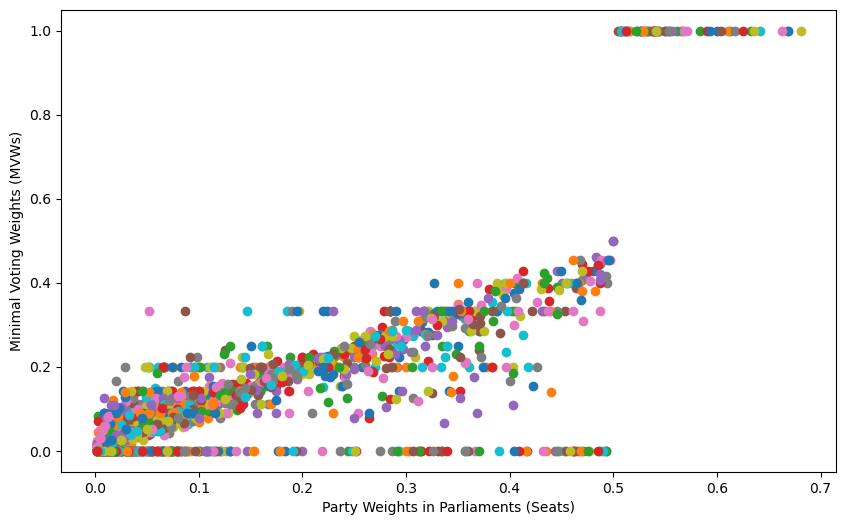

In [18]:
plt.figure(figsize=(10,6))
for parliament, zipped_data in plot_df.groupby('Parliament'): 
    plt.scatter(zipped_data['Seats'],zipped_data['mvw'])
plt.xlabel('Party Weights in Parliaments (Seats)')
plt.ylabel('Minimal Voting Weights (MVWs)')
plt.show()

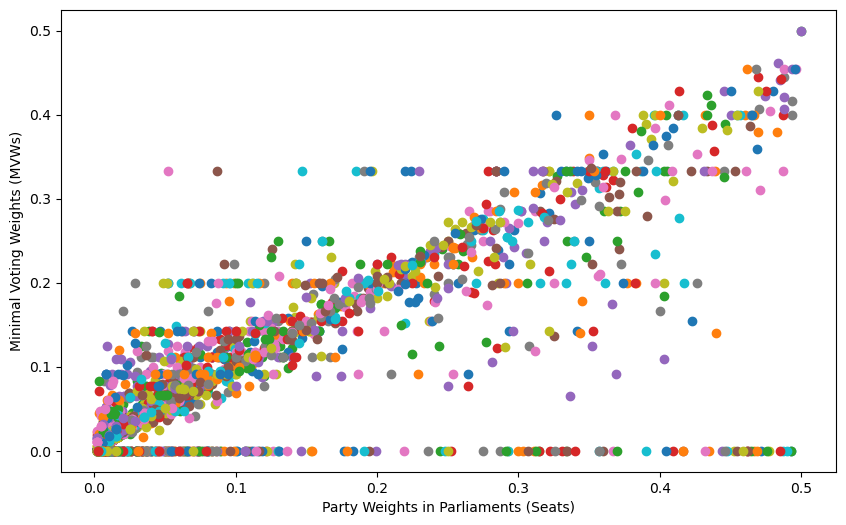

In [19]:
plt.figure(figsize=(10,6))
plot_df=plot_df[plot_df['mvw']<1]
for parliament, zipped_data in plot_df.groupby('Parliament'): 
    plt.scatter(zipped_data['Seats'],zipped_data['mvw'])
plt.xlabel('Party Weights in Parliaments (Seats)')
plt.ylabel('Minimal Voting Weights (MVWs)')
plt.show()

In [30]:
rel_indices= ['mvws','Seats','unweighted','weighted']
df=final_df.loc[rel_indices]
df=df.dropna(axis=1,how='any')

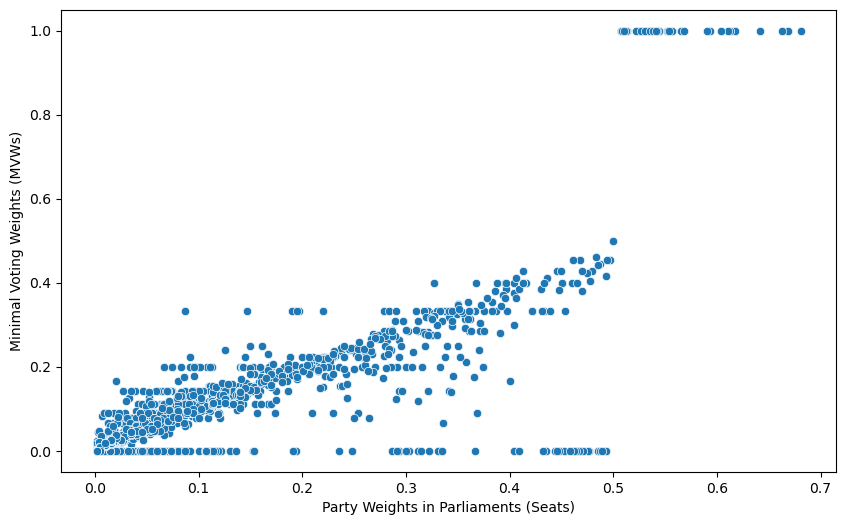

In [31]:
plot_data= []
indice=['mvws','Seats']
df.loc[indice]=df.loc[indice].applymap(ast.literal_eval).applymap(np.array)
df.loc['mvws']=df.loc['mvws'].apply(lambda x:x/np.sum(x))
df.loc['Seats']=df.loc['Seats'].apply(lambda x:x/np.sum(x))
df.loc['unweighted']=df.loc['unweighted'].apply(lambda x:x/np.sum(x))
df.loc['weighted']=df.loc['weighted'].apply(lambda x:x/np.sum(x))
for col in final_df.columns: 
    try:
        for counting, (mvw,seats,unweighted,weighted) in enumerate(zip(df[col]['mvws'],df[col]['Seats'],df[col]['unweighted'],df[col]['weighted'])): 
            plot_data.append({'Parliament': col, 'Party': counting, 'mvw': mvw,'Seats':seats,'unweighted Ministries':unweighted,'weighted Ministries':weighted})
    except KeyError: pass        
plot_df=pd.DataFrame(plot_data)
plt.figure(figsize=(10,6))
sns.scatterplot(data=plot_df, x='Seats', y='mvw')
plt.xlabel('Party Weights in Parliaments (Seats)')
plt.ylabel('Minimal Voting Weights (MVWs)')
plt.show()


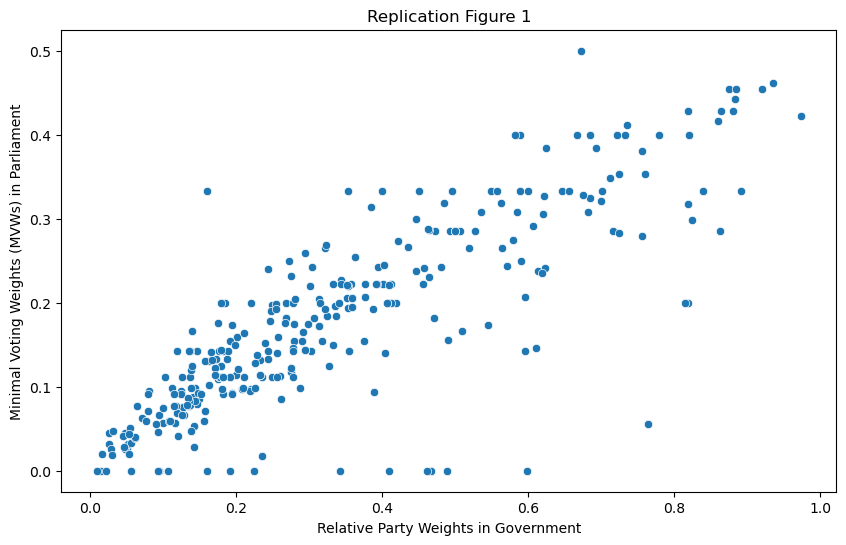

In [43]:

plot_data= []
share_in_gov=[]
for col in df.columns: 
    seats= df.loc['Seats',col]
    unweighted=df.loc['unweighted',col]
    in_gov_mask=unweighted>0 
    size_of_gov=np.sum(seats[in_gov_mask])
    share_in_gov_col=np.zeros_like(seats)
    share_in_gov_col[in_gov_mask]=seats[in_gov_mask]/size_of_gov
    share_in_gov.append(share_in_gov_col)
df.loc['% in gov',:]= share_in_gov
for col in final_df.columns: 
    try:
        for counting, (mvw,seats,unweighted,weighted,gov_share) in enumerate(zip(df[col]['mvws'],df[col]['Seats'],df[col]['unweighted'],df[col]['weighted'],df[col]['% in gov'])): 
            plot_data.append({'Parliament': col, 'Party': counting, 'mvw': mvw,'Seats':seats,'unweighted Ministries':unweighted,'weighted Ministries':weighted,'gov_share':gov_share})
    except KeyError: pass        
plot_df=pd.DataFrame(plot_data)
plot_df=plot_df[plot_df['gov_share']>0]
plot_df=plot_df[plot_df['gov_share']<1]
plot_df=plot_df[plot_df['mvw']<1]
plt.figure(figsize=(10,6))
sns.scatterplot(data=plot_df, x='gov_share', y='mvw')
plt.xlabel('Relative Party Weights in Government')
plt.ylabel('Minimal Voting Weights (MVWs) in Parliament')
plt.title('Replication Figure 1')
plt.show()

## Scatter Plot Seat Share ~ Ministries & MVW ~ Ministries

In [34]:
plot_data= []
for col in final_df.columns: 
    try:
        for counting, (mvw,seats,unweighted,weighted) in enumerate(zip(df[col]['mvws'],df[col]['Seats'],df[col]['unweighted'],df[col]['weighted'])): 
            plot_data.append({'Parliament': col, 'Party': counting, 'mvw': mvw,'Seats':seats,'unweighted Ministries':unweighted,'weighted Ministries':weighted})
    except KeyError: pass        
plot_df=pd.DataFrame(plot_data)
plot_df.dropna(subset=['unweighted Ministries'],inplace=True)
plot_df=plot_df[plot_df['mvw']<1]
plot_df=plot_df[plot_df['unweighted Ministries']>0]
plot_df=plot_df[plot_df['unweighted Ministries']<1]

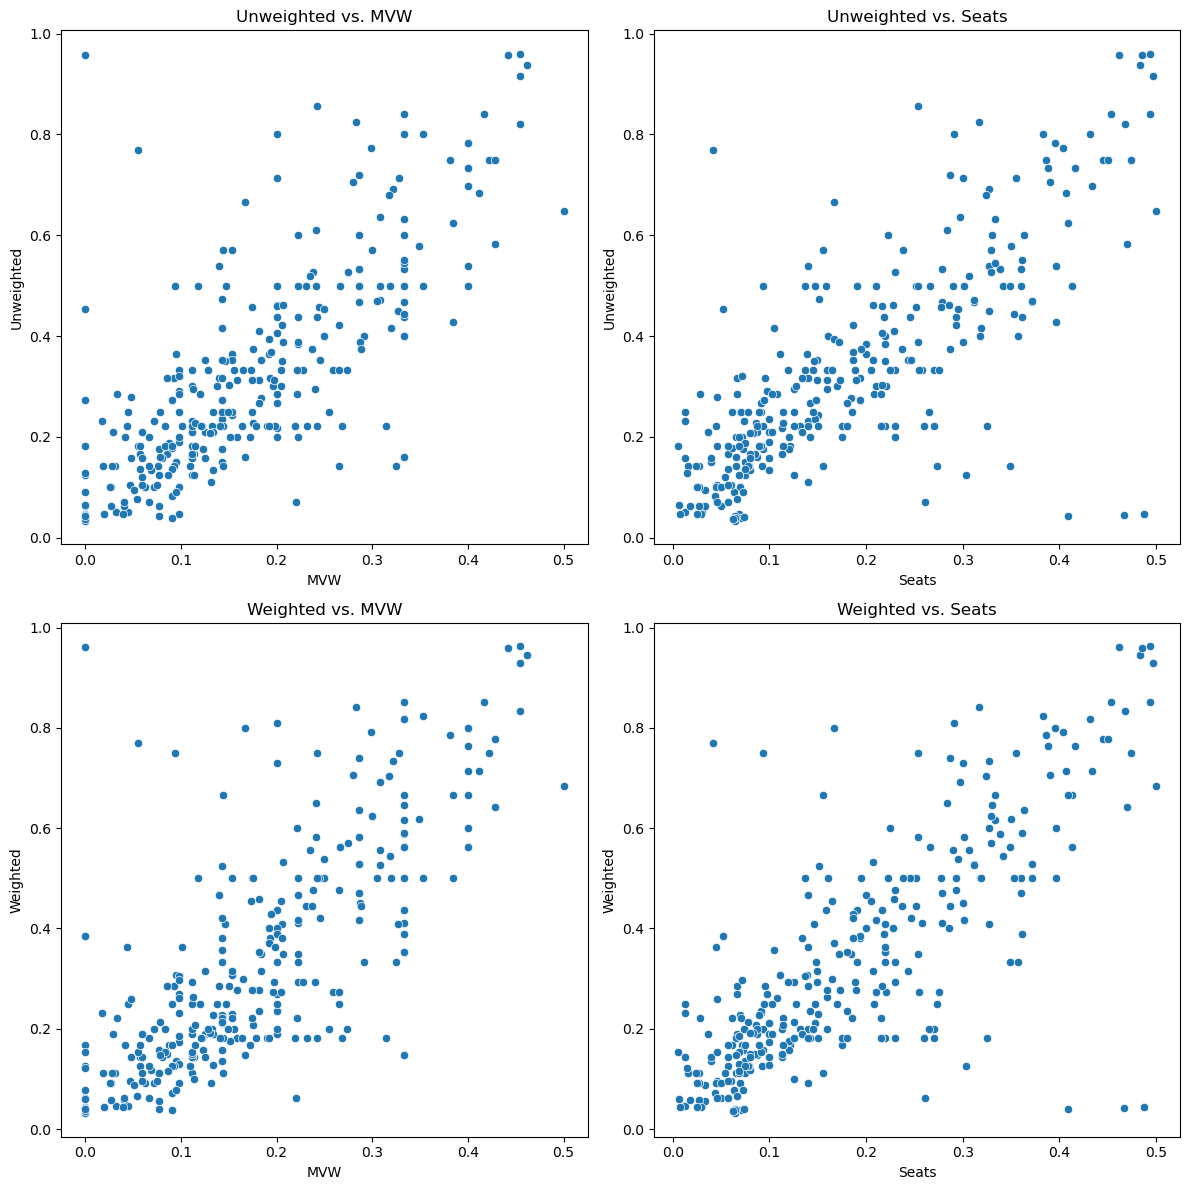

In [35]:
fig,axes= plt.subplots(2,2,figsize=(12,12))
###data:
sns.scatterplot(data=plot_df, x='mvw', y='unweighted Ministries', ax=axes[0, 0])
sns.scatterplot(data=plot_df, x='Seats', y='unweighted Ministries', ax=axes[0, 1])
sns.scatterplot(data=plot_df, x='mvw', y='weighted Ministries', ax=axes[1, 0])
sns.scatterplot(data=plot_df, x='Seats', y='weighted Ministries', ax=axes[1, 1])
### labels: 
axes[0, 0].set_title('Unweighted vs. MVW')
axes[0, 0].set_xlabel('MVW')
axes[0, 0].set_ylabel('Unweighted')

axes[0, 1].set_title('Unweighted vs. Seats')
axes[0, 1].set_xlabel('Seats')
axes[0, 1].set_ylabel('Unweighted')

axes[1, 0].set_title('Weighted vs. MVW')
axes[1, 0].set_xlabel('MVW')
axes[1, 0].set_ylabel('Weighted')

axes[1, 1].set_title('Weighted vs. Seats')
axes[1, 1].set_xlabel('Seats')
axes[1, 1].set_ylabel('Weighted')

### plot
plt.tight_layout()
plt.show()

In [45]:
print(14**2)

196
